<a href="https://colab.research.google.com/github/Nrulafind/Dicoding-Submission-Classification-Image_CNN-Model/blob/main/Image_Classification_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import zipfile


In [ ]:
# Extract zip file
# with zipfile.ZipFile('/content/drive/MyDrive/Local Project/Dicoding/Dicoding-Belajar Pengembangan Machine Learning/assignment_3_Image Classification Model Deployment/images.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/Local Project/Dicoding/Dicoding-Machine learning untuk pemula/images_zip/')
try:
    with zipfile.ZipFile('/content/drive/MyDrive/Local Project/Dicoding/Dicoding-Belajar Pengembangan Machine Learning/assignment_3_Image Classification Model Deployment/myntradataset.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/drive/MyDrive/Local Project/Dicoding/Dicoding-Belajar Pengembangan Machine Learning/assignment_3_Image Classification Model Deployment/myntradataset/')
    print("Extraction successful.")
except Exception as e:
    print(f"Error during extraction: {e}")

DATASET_PATH = '/content/drive/MyDrive/Local Project/Dicoding/Dicoding-Belajar Pengembangan Machine Learning/assignment_3_Image Classification Model Deployment/myntradataset//myntradataset/'
print(os.listdir(DATASET_PATH))

Error during extraction: [Errno 5] Input/output error: '/content/drive/MyDrive/Local Project/Dicoding/Dicoding-Belajar Pengembangan Machine Learning/assignment_3_Image Classification Model Deployment/myntradataset/myntradataset/images/10000.jpg'
['images', 'styles.csv']


In [ ]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=26000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.info()

# Encode the 'masterCategory' column
label_encoder = LabelEncoder()
df['masterCategory'] = label_encoder.fit_transform(df['masterCategory']).astype(str)

# Fungsi untuk memuat dataset
def load_dataset():

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Use flow_from_dataframe to load images and labels from the DataFrame
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=DATASET_PATH + "images",
        x_col='image',
        y_col='masterCategory',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=DATASET_PATH + "images",
        x_col='image',
        y_col='masterCategory',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    # Print dataset information
    print(df.head())
    print("")
    print("Unique categories:", label_encoder.classes_)
    print("Image:", df['image'])

    print("Total training samples:", len(train_generator.filenames))
    print("Total validation samples:", len(validation_generator.filenames))

    return train_generator, validation_generator

<ipython-input-5-258cf98e1d08>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=26000, error_bad_lines=False)
Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26000 entries, 0 to 25999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  26000 non-null  int64  
 1   gender              26000 non-null  object 
 2   masterCategory      26000 non-null  object 
 3   subCategory         26000 non-null  object 
 4   articleType         26000 non-null  object 
 5   baseColour          25990 non-null  object 
 6   season              25990 non-null  object 
 7   year                25999 non-null  float64
 8   usage               25817 non-null  object 
 9   productDisplayName  25995 non-null  object 
 10  image               26000 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 2.2+ MB


In [ ]:

# Fungsi untuk membuat model CNN
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.Dense(1, activation='sigmoid'))
    model.add(layers.Dense(7, activation='softmax'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:

# Fungsi untuk membuat callback
def create_callbacks():
    # Tambah callback
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ]
    return callbacks

In [ ]:
def train_model(model, train_generator, validation_generator):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=create_callbacks()
    )
    return history

In [ ]:
# Fungsi untuk membuat plot akurasi
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
# Fungsi untuk membuat plot loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Fungsi untuk menyimpan model ke dalam format TF-Lite
def save_model_to_tflite(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open('model.tflite', 'wb') as f:
        f.write(tflite_model)

In [ ]:
# Memuat dataset
train_generator, validation_generator = load_dataset()

Found 20799 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 5199 validated image filenames belonging to 7 classes.
      id gender masterCategory subCategory   articleType baseColour  season  \
0  34353    Men              1     Topwear       Tshirts       Blue  Summer   
1  47199    Men              2       Shoes  Formal Shoes      Brown  Summer   
2  17238    Men              1     Topwear       Tshirts      Black    Fall   
3   8981    Men              2       Shoes  Casual Shoes      White    Fall   
4   5614    Men              2      Sandal       Sandals      Brown  Summer   

     year   usage                            productDisplayName      image  
0  2012.0  Casual          Myntra Men Blue Diet Extreme T-shirt  34353.jpg  
1  2012.0  Formal      Franco Leone Men Dark Brown Formal Shoes  47199.jpg  
2  2011.0  Casual  U.S. Polo Assn. Men Solid Black  Polo Tshirt  17238.jpg  
3  2011.0  Casual    Puma Men Evo Ducati Mid White Casual Shoes   8981.jpg  
4  2011.0  Casual               ADIDAS Men Henrio Brown Floater   5614.jpg  

U

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Membuat model
model = create_model()


In [ ]:
# Melatih model
history = train_model(model, train_generator, validation_generator)


Epoch 1/50
650/650 [==============================] - 8008s 12s/step - loss: 0.3172 - accuracy: 0.9148 - val_loss: 0.2044 - val_accuracy: 0.9410
Epoch 2/50
650/650 [==============================] - 72s 111ms/step - loss: 0.1309 - accuracy: 0.9608 - val_loss: 0.2227 - val_accuracy: 0.9340
Epoch 3/50
650/650 [==============================] - 69s 106ms/step - loss: 0.0899 - accuracy: 0.9723 - val_loss: 0.2185 - val_accuracy: 0.9410
Epoch 4/50
650/650 [==============================] - 70s 107ms/step - loss: 0.0805 - accuracy: 0.9745 - val_loss: 0.2397 - val_accuracy: 0.9575
Epoch 5/50
650/650 [==============================] - 68s 105ms/step - loss: 0.0348 - accuracy: 0.9896 - val_loss: 0.2417 - val_accuracy: 0.9646
Epoch 6/50
650/650 [==============================] - 72s 110ms/step - loss: 0.0194 - accuracy: 0.9940 - val_loss: 0.2460 - val_accuracy: 0.9615
Epoch 7/50
650/650 [==============================] - 71s 110ms/step - loss: 0.0302 - accuracy: 0.9917 - val_loss: 0.2758 - val_ac

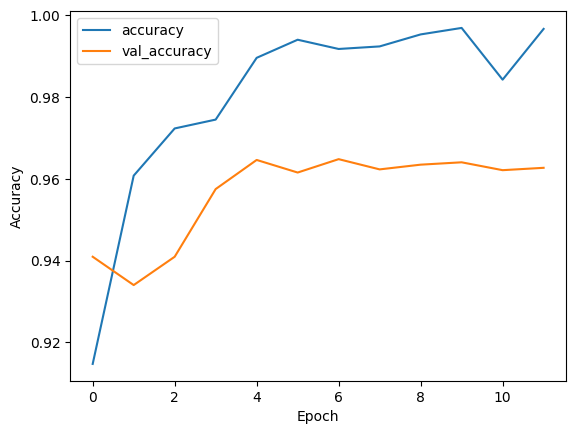

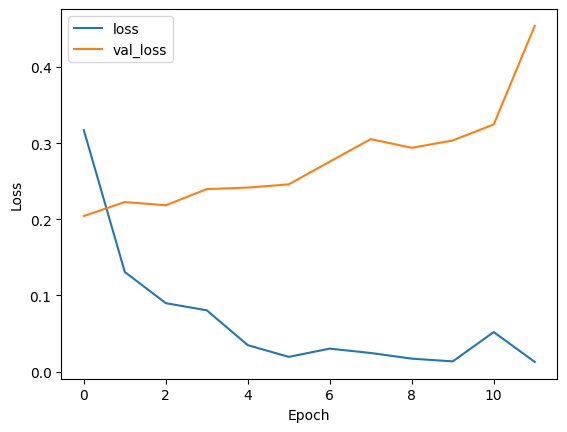

In [ ]:
# Membuat plot akurasi dan loss
plot_history(history)

In [ ]:
# Menyimpan model ke dalam format TF-Lite
save_model_to_tflite(model)